In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 752ms/step - loss: 0.0283
Average validation loss: 0.6568874716758728
4/4 [==============================] - 7s 768ms/step - loss: 0.0283 - val_loss: 0.6569
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 10s 756ms/step - loss: 0.0206 - val_loss: 0.6569
Average validation loss: 0.793054461479187
4/4 [==============================] - 10s 769ms/step - loss: 0.0206 - val_loss: 0.7250
Epoch 3/10
4/4 [==============================] - 14s 789ms/step - loss: 0.0158 - val_loss: 0.7250
Average validation loss: 0.6449675559997559
4/4 [==============================] - 14s 797ms/step - loss: 0.0158 - val_loss: 0.6983
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_siz

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 745ms/step - loss: 7.8088e-04
Average validation loss: 0.004561044974252582
8/8 [==============================] - 6s 762ms/step - loss: 7.8088e-04 - val_loss: 0.0046
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 743ms/step - loss: 7.3072e-04 - val_loss: 0.0046
Average validation loss: 0.00275513983797282
8/8 [==============================] - 12s 756ms/step - loss: 7.3072e-04 - val_loss: 0.0037
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 765ms/step - loss: 7.1964e-04 - val_loss: 0.0037
Average validation loss: 0.025257956236600876
8/8 [==============================] - 18s 778ms/s

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 713ms/step - loss: 8.8118e-04
Average validation loss: 0.05417599828751918
12/12 [==============================] - 9s 728ms/step - loss: 8.8118e-04 - val_loss: 0.0542
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 706ms/step - loss: 8.7927e-04 - val_loss: 0.0542
Average validation loss: 0.1828207472960154
12/12 [==============================] - 17s 719ms/step - loss: 8.7927e-04 - val_loss: 0.1185
Epoch 3/10
12/12 [==============================] - 26s 703ms/step - loss: 8.7512e-04 - val_loss: 0.1185
Average validation loss: 0.05966647590200106
12/12 [==============================] - 26s 715ms/step - loss: 8.7512e-04 - val_loss: 0.0989
Epoch 4/10
12/12 [==============================] - 35s 706ms/step - loss: 8.7554e-04 - val_loss: 0.0989
Average validation l

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 754ms/step - loss: 8.6583e-04
Average validation loss: 0.279219426214695
16/16 [==============================] - 12s 764ms/step - loss: 8.6583e-04 - val_loss: 0.2792
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 708ms/step - loss: 8.3165e-04 - val_loss: 0.2792
Average validation loss: 0.04280970967374742
16/16 [==============================] - 24s 721ms/step - loss: 8.3165e-04 - val_loss: 0.1610
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 713ms/step - loss: 8.1652e-04 - val_loss: 0.1610
Average validation loss: 0.02935538688325323
16/16 [==============================] - 3

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 731ms/step - loss: 6.1449e-04
Average validation loss: 0.059976349025964736
20/20 [==============================] - 15s 744ms/step - loss: 6.1449e-04 - val_loss: 0.0600
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 705ms/step - loss: 5.7106e-04 - val_loss: 0.0600
Average validation loss: 0.29379517436027525
20/20 [==============================] - 29s 717ms/step - loss: 5.7106e-04 - val_loss: 0.1769
Epoch 3/10
20/20 [==============================] - 43s 711ms/step - loss: 5.4710e-04 - val_loss: 0.1769
Average validation loss: 0.15714737474918367
20/20 [==============================] - 44s 724ms/step - loss: 5.4710e-04 - val_loss: 0.1703
Epoch 4/10
20/20 [==============================] - 58s 711ms/step - loss: 5.2933e-04 - val_loss: 0.1703
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 710ms/step - loss: 4.8974e-04
Average validation loss: 0.8074246446291605
24/24 [==============================] - 17s 721ms/step - loss: 4.8974e-04 - val_loss: 0.8074
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 712ms/step - loss: 4.9077e-04 - val_loss: 0.8074
Average validation loss: 0.31849414606889087
24/24 [==============================] - 35s 724ms/step - loss: 4.9077e-04 - val_loss: 0.5630
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 710ms/step - loss: 4.7726e-04 - val_loss: 0.5630
Average validation loss: 0.1373657062649727
24/24 [==============================] - 5

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 714ms/step - loss: 5.9751e-04
Average validation loss: 0.14027606844902038
40/40 [==============================] - 29s 725ms/step - loss: 5.9751e-04 - val_loss: 0.1403
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 710ms/step - loss: 5.6322e-04 - val_loss: 0.1403
Average validation loss: 0.10805058404803276
40/40 [==============================] - 58s 723ms/step - loss: 5.6322e-04 - val_loss: 0.1242
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 86s 714ms/step - loss: 5.4618e-04 - val_loss: 0.1242
Average validation loss: 0.07905501276254653
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 712ms/step - loss: 5.0003e-04
Average validation loss: 0.16153373724470535
48/48 [==============================] - 35s 724ms/step - loss: 5.0003e-04 - val_loss: 0.1615
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 718ms/step - loss: 4.5801e-04 - val_loss: 0.1615
Average validation loss: 0.21647920707861582
48/48 [==============================] - 70s 729ms/step - loss: 4.5801e-04 - val_loss: 0.1890
Epoch 3/10
48/48 [==============================] - 105s 724ms/step - loss: 4.2953e-04 - val_loss: 0.1890
Average validation loss: 0.1423564733316501
48/48 [==============================] - 105s 735ms/step - loss: 4.2953e-04 - val_loss: 0.1735
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/wei

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 715ms/step - loss: 4.9985e-04
Average validation loss: 0.0647935216761003
56/56 [==============================] - 41s 727ms/step - loss: 4.9985e-04 - val_loss: 0.0648
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 718ms/step - loss: 4.3981e-04 - val_loss: 0.0648
Average validation loss: 0.2809498787391931
56/56 [==============================] - 82s 729ms/step - loss: 4.3981e-04 - val_loss: 0.1729
Epoch 3/10
56/56 [==============================] - 122s 727ms/step - loss: 4.0775e-04 - val_loss: 0.1729
Average validation loss: 0.08960664930678572
56/56 [==============================] - 123s 738ms/step - loss: 4.0775e-04 - val_loss: 0.1451
Epoch 4/10
56/56 [==============================] - 163s 722ms/step - loss: 3.8381e-04 - val_loss: 0.1451
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 725ms/step - loss: 3.4745e-04
Average validation loss: 0.11885118362806679
64/64 [==============================] - 47s 737ms/step - loss: 3.4745e-04 - val_loss: 0.1189
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 719ms/step - loss: 3.1668e-04 - val_loss: 0.1189
Average validation loss: 0.08297675998437626
64/64 [==============================] - 94s 731ms/step - loss: 3.1668e-04 - val_loss: 0.1009
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 711ms/step - loss: 2.9739e-04 - val_loss: 0.1009
Average validation loss: 0.053894385846703585
64/64 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 718ms/step - loss: 3.1914e-04
Average validation loss: 0.08951881134675609
72/72 [==============================] - 52s 729ms/step - loss: 3.1914e-04 - val_loss: 0.0895
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 717ms/step - loss: 2.8375e-04 - val_loss: 0.0895
Average validation loss: 0.06295008233024015
72/72 [==============================] - 105s 728ms/step - loss: 2.8375e-04 - val_loss: 0.0762
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 157s 717ms/step - loss: 2.6299e-04 - val_loss: 0.0762
Average validation loss: 0.07305331321226226
72/72 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 716ms/step - loss: 2.9257e-04
Average validation loss: 0.045753675326704976
80/80 [==============================] - 58s 727ms/step - loss: 2.9257e-04 - val_loss: 0.0458
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 724ms/step - loss: 2.5258e-04 - val_loss: 0.0458
Average validation loss: 0.08780104480683804
80/80 [==============================] - 117s 736ms/step - loss: 2.5258e-04 - val_loss: 0.0668
Epoch 3/10
80/80 [==============================] - 175s 719ms/step - loss: 2.2322e-04 - val_loss: 0.0668
Average validation loss: 0.06551848463714123
80/80 [==============================] - 176s 730ms/step - loss: 2.2322e-04 - val_loss: 0.0664
Epoch 4/10
80/80 [==============================] - 233s 714ms/step - loss: 2.0461e-04 - val_loss: 0.0664
Average va

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 70s 724ms/step - loss: 4.0809e-04
Average validation loss: 0.1700729774311185
96/96 [==============================] - 71s 735ms/step - loss: 4.0809e-04 - val_loss: 0.1701
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 714ms/step - loss: 3.3778e-04 - val_loss: 0.1701
Average validation loss: 0.07051827071700245
96/96 [==============================] - 140s 725ms/step - loss: 3.3778e-04 - val_loss: 0.1203
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 716ms/step - loss: 2.9438e-04 - val_loss: 0.1203
Average validation loss: 0.09549891017377377
96/96 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 717ms/step - loss: 2.8834e-04
Average validation loss: 0.15471911849454045
120/120 [==============================] - 87s 728ms/step - loss: 2.8834e-04 - val_loss: 0.1547
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 718ms/step - loss: 2.5987e-04 - val_loss: 0.1547
Average validation loss: 0.09790304237200569
120/120 [==============================] - 175s 729ms/step - loss: 2.5987e-04 - val_loss: 0.1263
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 720ms/step - loss: 2.2929e-04 - val_loss: 0.1263
Average validation loss: 0.11931736217811703
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 715ms/step - loss: 2.5483e-04
Average validation loss: 0.1175224016317063
144/144 [==============================] - 105s 726ms/step - loss: 2.5483e-04 - val_loss: 0.1175
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 719ms/step - loss: 2.1721e-04 - val_loss: 0.1175
Average validation loss: 0.08448703550837106
144/144 [==============================] - 210s 731ms/step - loss: 2.1721e-04 - val_loss: 0.1010
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 314s 724ms/step - loss: 1.9408e-04 - val_loss: 0.1010
Average validation loss: 0.07593157364883357
144/144 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 718ms/step - loss: 2.0669e-04
Average validation loss: 0.14819143763861575
160/160 [==============================] - 117s 729ms/step - loss: 2.0669e-04 - val_loss: 0.1482
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 716ms/step - loss: 1.8261e-04 - val_loss: 0.1482
Average validation loss: 0.1363442281422941
160/160 [==============================] - 233s 727ms/step - loss: 1.8261e-04 - val_loss: 0.1423
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 348s 715ms/step - loss: 1.6355e-04 - val_loss: 0.1423
Average validation loss: 0.06885971972363905
160/160 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 717ms/step - loss: 3.3559e-04
Average validation loss: 0.27662775713085463
200/200 [==============================] - 146s 728ms/step - loss: 3.3559e-04 - val_loss: 0.2766
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 718ms/step - loss: 2.9157e-04 - val_loss: 0.2766
Average validation loss: 0.11996202364360214
200/200 [==============================] - 292s 729ms/step - loss: 2.9157e-04 - val_loss: 0.1983
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 435s 717ms/step - loss: 2.5753e-04 - val_loss: 0.1983
Average validation loss: 0.097020604368779
200/200 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:54 - loss: 7.7942e-05

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 715ms/step - loss: 2.3685e-04
Average validation loss: 0.08256420782706377
240/240 [==============================] - 174s 726ms/step - loss: 2.3685e-04 - val_loss: 0.0826
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 717ms/step - loss: 2.0207e-04 - val_loss: 0.0826
Average validation loss: 0.16123464800785386
240/240 [==============================] - 349s 728ms/step - loss: 2.0207e-04 - val_loss: 0.1219
Epoch 3/10
240/240 [==============================] - 522s 719ms/step - loss: 1.7874e-04 - val_loss: 0.1219
Average validation loss: 0.1163904062578581
240/240 [==============================] - 524s 730ms/step - loss: 1.7874e-04 - val_loss: 0.1201
Epoch 4/10
240/240 [==============================] - 697s 718ms/step - loss: 1.6790e-04 - val_loss: 0.1

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11035776148437604, 0.06140026683237238, 0.09110797124851311, 0.13241336802660952, 0.15155086500478046, 0.1555812850401465, 0.15359836821909995, 0.11722391400020568, 0.094402967588519, 0.07322436410906193, 0.06401383114812972, 0.06863235003526597, 0.08565176683996023, 0.0880845772081196, 0.0878282893284501, 0.07622621003358011, 0.08929554324360948, 0.08266234330249872]
std_val_losses =  [0.18433275095489002, 0.06815688620982926, 0.06931770039396645, 0.08855308742616487, 0.10345367465812293, 0.11353795620943066, 0.06604688795404556, 0.08015185018783197, 0.03963135389349661, 0.02369808088487241, 0.01601925824098322, 0.02686607950319845, 0.029036421867319584, 0.03490867181887054, 0.04036604380621763, 0.02651873298693027, 0.03992690806511601, 0.03704309836899392]


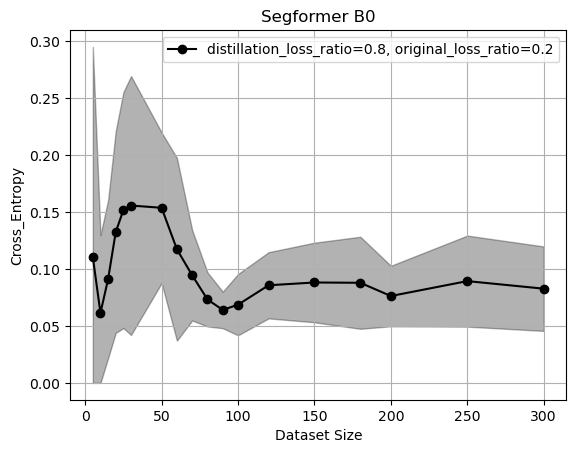

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()